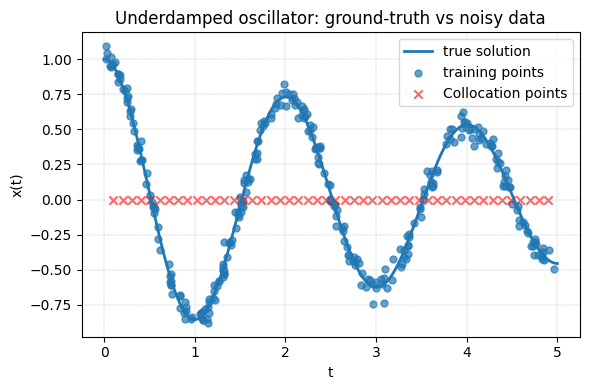

In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 0.5          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 50

data_noise = 0.05
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(100, data_noise)


# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [ ]:

# ────────────────────────────────────────────────────────────────────────────────
# 4. Build HMC-BPINN (1 input → 1 output)
# ────────────────────────────────────────────────────────────────────────────────
from utils_uqmd.utils_uq_hmc import HMCBPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[32, 32, 32, 32],
    "output_dim":1,
    "prior_std":0.5
}

# Model
hmc_model = HMCBPINN(
    **model_args
)


# ────────────────────────────────────────────────────────────────────────────────
# 5. Hyper-parameter grid & CP settings
# ────────────────────────────────────────────────────────────────────────────────
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=[20000],
    λ_pde=[1.0, 3.50, 5.0], λ_ic=[5.0, 10.0, 15.0], λ_data=[5.0, 2.5, 1.0],
    hmc_samples=[30000],
    burn_in = [5000],
    step_size = [1e-4],
    leapfrog_steps = [15],
    lr=[1e-3], stop_schedule=[20000]
)

baseline_pred_kwargs = dict(n_samples=000)

# Conformal-prediction settings
alphas = torch.linspace(0.01, 0.99, 20)

from utils_uqmd.utils_uq_cp import CP

# CP Model
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_coverage_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":10
}

baseline_coverage_args = { 
    # "uqmodel":hmc_model
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":5000
}


# ────────────────────────────────────────────────────────────────────────────────
# 6. Launch tuning with the NEW 1-D coverage plot
# ────────────────────────────────────────────────────────────────────────────────
from utils_tools.utils_tuning       import hyperparameter_tuning
from utils_tools.utils_result_viz   import plot_1D_comparison_with_coverage
from utils_tools.utils_result_metrics import (
    do_test_uncertainties, cp_test_uncertainties, hmc_test_uncertainties
)


hyperparameter_tuning(
    plot_title="Dopout CP Model", # Change this
    # Model Fitting & Predicting
    uqmodel=hmc_model,  # Change this|
    alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_testing_args=baseline_coverage_args, cp_testing_args=cp_coverage_args,
    baseline_test_uncertainties=hmc_test_uncertainties, # Change this
    # Plotting function
    plotting_func=plot_1D_comparison_with_coverage, # Change this
    save_dir="1doscil_hmc_cp", # Change this
    X_vis=X_train, Y_vis=Y_train,
    X_validation=X_train, Y_validation=Y_train
)


[🔎] Trying: {'epochs': 1000, 'λ_pde': 3.5, 'λ_ic': 5.0, 'λ_data': 1.0, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0001, 'leapfrog_steps': 15, 'lr': 0.009, 'stop_schedule': 20000}

[🟠] Training...


MAP:  54%|█████▎    | 535/1000 [00:01<00:01, 307.02it/s, loss=2.56e-01]

[MAP] epoch    500 −logPost=2.564e-01  Data=2.56e-01  PDE=6.53e-06  IC=9.99e-01  BC=0.00e+00


[MAP] epoch   1000 −logPost=2.564e-01  Data=2.56e-01  PDE=6.53e-06  IC=9.99e-01  BC=0.00e+00


KeyboardInterrupt: 